In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
from IPython.display import HTML
import time
from torchvision import models
import torch.nn.functional as F
from scipy import linalg

In [16]:
dataset = datasets.CIFAR10(root="/scratch1/shounak/dataset/CIFAR10data", download=False,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                         shuffle=True, num_workers=2)

device = torch.device("cuda")

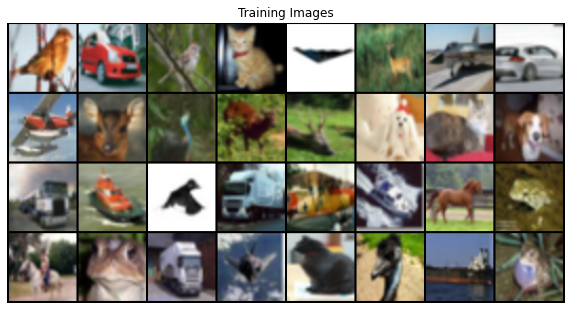

In [17]:
Original_batch1 = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(Original_batch1[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [18]:
class DiscriminatorPP(nn.Module):
    def __init__(self, channels_img, features_d):
        super(DiscriminatorPP, self).__init__()
        self.disc = nn.Sequential(
            
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
         
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [19]:
class GeneratorPP(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(GeneratorPP, self).__init__()
        self.net = nn.Sequential(
            
            
            self._block(channels_noise, features_g * 16, 4, 1, 0),  
            self._block(features_g * 16, features_g * 8, 4, 2, 1), 
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
           
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [20]:
def initialize_weights(model):
    
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [21]:
class InceptionV3(nn.Module):
    

    
    DEFAULT_BLOCK_INDEX = 3

  
    BLOCK_INDEX_BY_DIM = {
        64: 0,
        192: 1,
        768: 2,
        2048: 3
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

       
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

       
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_index = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_index])
model=model.cuda()

In [22]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
       
    assert sigma1.shape == sigma2.shape, \
        

    diff = mu1 - mu2

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1 = calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2 = calculate_activation_statistics(images_fake,model,cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [23]:
lr = 5e-5
Z_DIM = 128
num_epochs = 50
WEIGHT_CLIP = 0.01

In [24]:
gen = Generator(Z_DIM, channels_img = 3, features_g = 64).to(device)
critic = Discriminator(channels_img = 3, features_d = 64).to(device)
initialize_weights(gen)
initialize_weights(critic)

In [25]:
opt_gen = optim.RMSprop(gen.parameters(), lr = lr)
opt_critic = optim.RMSprop(critic.parameters(), lr = lr)

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
step = 0

gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [ ]:
GenLoss = []
DiscLoss = []
img_list = []
fretchet_distances = []
iters = 0

for epoch in range(num_epochs):
   
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        cur_batch_size = data.shape[0]

        
        for _ in range(5): 
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_critic:.3f}, loss Generator: {loss_gen:.3f}"
            )
        
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_critic.detach().cpu())
        
        
        if (iters % 500 == 0) or ((epoch == num_epochs) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    fretchet_dist = calculate_fretchet(data, fake, model)
    fretchet_distances.append(fretchet_dist)
    print('Fretchet Distance: ', fretchet_dist)

Epoch [0/50] Batch 0/1563                   Loss Discriminator: -0.017, loss Generator: 0.009
Epoch [0/50] Batch 100/1563                   Loss Discriminator: -1.326, loss Generator: 0.661
Epoch [0/50] Batch 200/1563                   Loss Discriminator: -1.532, loss Generator: 0.761
Epoch [0/50] Batch 300/1563                   Loss Discriminator: -1.550, loss Generator: 0.769
Epoch [0/50] Batch 400/1563                   Loss Discriminator: -1.546, loss Generator: 0.767
Epoch [0/50] Batch 500/1563                   Loss Discriminator: -1.514, loss Generator: 0.756
Epoch [0/50] Batch 600/1563                   Loss Discriminator: -1.505, loss Generator: 0.752
Epoch [0/50] Batch 700/1563                   Loss Discriminator: -1.469, loss Generator: 0.731
Epoch [0/50] Batch 800/1563                   Loss Discriminator: -1.461, loss Generator: 0.736
Epoch [0/50] Batch 900/1563                   Loss Discriminator: -1.378, loss Generator: 0.712
Epoch [0/50] Batch 1000/1563              

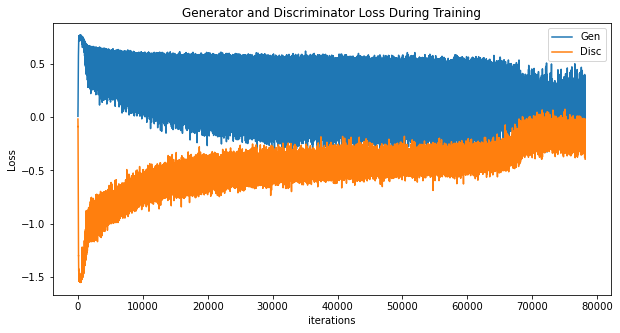

In [27]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Gen")
plt.plot(DiscLoss,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

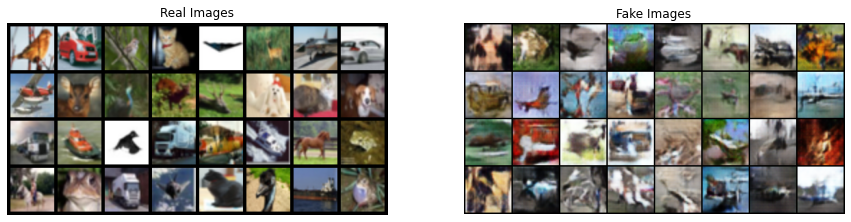

In [28]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('compare.png')
plt.show()

In [29]:
import pickle
with open('fd_wgan.pickle', 'wb') as f:
    pickle.dump(fretchet_distances, f)